# Python機械学習 勉強会 第十二回「モデルの評価と改良1」

参考文献：  
Pythonではじめる機械学習　5章  
https://github.com/amueller/introduction_to_ml_with_python/blob/master/05-model-evaluation-and-improvement.ipynb

scikit-learnドキュメント：  
https://scikit-learn.org/stable/documentation.html

In [1]:
%matplotlib inline
from preamble import *
from sklearn.model_selection import train_test_split

In [2]:
# ワーニングを無視
import warnings
warnings.filterwarnings('ignore')

# pandasの行や列を省略しないようにする
pd.options.display.max_columns = None
pd.options.display.max_rows = None

<br>

---

## はじめに

今回は以下の内容を取り組む

* 交差検証
* グリッドサーチ

<br>

---

## 5 モデルの評価と改良


この章ではモデルの評価方法とパラメータ選択について学んでいく。

これまで教師あり学習モデルを評価するさい、データセットを訓練・テストに分割し、  
訓練セットでモデルを構築し、テストセットに対して***score***メソッドで評価してきた。

scoreメソッドは、クラス分類に関しては「正しくクラス分類された割合」を計算する。

In [3]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# 合成データセットの生成
X, y = make_blobs(random_state=0)

# dataトラベルを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# モデルのインスタンスを生成し、訓練データで学習
logreg = LogisticRegression().fit(X_train, y_train)

# テストセットでモデルを評価
print("Test set score: {:.2f}".format(logreg.score(X_test, y_test)))

Test set score: 0.88


大事なのは、訓練時に用いていないデータで確認することで、汎化性能を評価すること。

ここでは、今まで扱った方法よりも強力な汎化性能評価手法である**交差検証(cross-validation)**を導入する。  
また、汎化性能が最大になるように効率的にパラメータを調整する手法であるグリッドサーチについても学んでいく。

<br>

---

### 5.1 交差検証

交差検証は汎化性能を評価する手法であり、ただ訓練セットとテストセットを分割する手法と比べて、より安定で徹底した手法。

交差検証は、データの分割を何度も繰り返して行い、複数のモデルを訓練することで評価する。

具体的に図を用いて、**k分割交差検証(k-fold cross-validation)**について学んでいく。

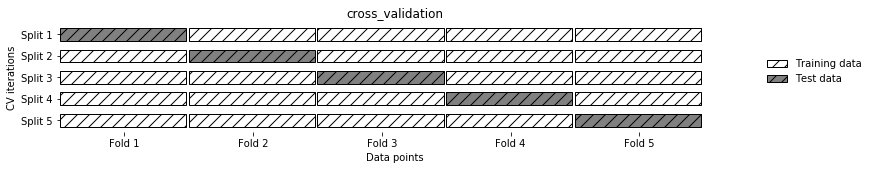

In [4]:
mglearn.plots.plot_cross_validation()

k分割交差検証では、データをk分割し、1つの分割(これを**fold**と呼ぶ)をテストセット、残りのk-1個を訓練セットとして学習・評価する。

これをkパターン繰り返すことで、最終的にk個のモデルに対する性能が評価できる。

* kはユーザーが定める数字で、一般的には5～10程度である

<br>

#### 5.1.1 scikit-learnでの交差検証

交差検証はscikit-learnではmodel_selectionモジュールの***cross_val_score***関数として実装されている。

irisデータセットを例にLogisticRegressionで評価してみる。

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.961 0.922 0.958]


cross_val_scoreは、デフォルトで3分割交差検証を行い、3つの精度を返す。  
分割数を変えたければ***cv***パラメータで指定できる。

In [6]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [1.    0.967 0.933 0.9   1.   ]


この方法ではk個の性能が出力されるが、一般的には平均を用いてモデルの性能とする。

In [7]:
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Average cross-validation score: 0.96


この例では、このモデルは平均で96%の割合で正しいだろうと結論できる。

ただし、5分割交差検証の結果の5つの精度を確認すると90%～100%とバラつきが大きい。  
これは、このモデルは訓練に用いた特定の分割に強く依存しているか、そもそもデータセットのサイズがただ小さすぎるのかもしれない。

モデルの性能を結論付けるには、こういった分割の依存なども考慮する必要がある。

<br>

#### 5.1.2 交差検証の利点

交差検証の利点として、ランダムサンプリングによる評価値のバラつきを考慮することができることが挙げられる。

具体的に考える。  

交差検証ではなく今まで取り扱ってきたtrain_test_splitは、ランダムに訓練セットとテストに分割する。  
この時、もし分類が難しいデータだけが訓練セットに入り、簡単なデータだけがテストに入った場合、  
性能はありえないほど高くなってしまう。逆も同様。

交差検証では、**すべてのデータが1度はテストに用いられる**。  
そのため、データ分割のランダム性による評価値バラつき(性能の誤見積もり)を考慮することができる。

<br>

もう1つの利点は、train_test_splitと比較してデータをより効率的に学習に使えるということである。  
train_test_splitでは通常75%を訓練データとして用いるが、5分割交差検証の場合は4/5(80%)、10分割なら9/10(90%)を訓練に使える。

<br>

欠点として挙げられるのは計算コスト。  
単純にk個のモデルを訓練するため、単純な分割と比較してk倍時間がかかる。

<br>

#### 5.1.3 層化k分割交差検証と他の戦略

前項では単純に先頭から1/k分割をテスト、(k-1)/k分割を訓練、といった方法で分割していたが、  
実際のデータセットを考慮するとうまくいかない場合も多い。

具体例で確認する。

In [8]:
iris = load_iris()
print("Iris labels:\n{}".format(iris.target))

Iris labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


例えば、irisデータセットでは、データの最初1/3はクラス0、次の1/3はクラス1、…といった構成になっている。

これらを単純に先頭から3分割交差検証を行った場合、最初の1/3分割(クラス0のみ)をテスト、残り(クラス1と2のみ)を訓練と分割するため、  
訓練セットに一切含まれていないデータを評価することになる。

これでは正確に評価できているとは言えない。

<br>

そこで、scikit-learnはクラス分類の場合は**層化k分割交差検証(stratified k-fold cross-validation)**を自動で用いる。

層化交差検証では、k分割内でのクラスの比率が、全体の比率と同じになるように分割する。  
図で確認する。

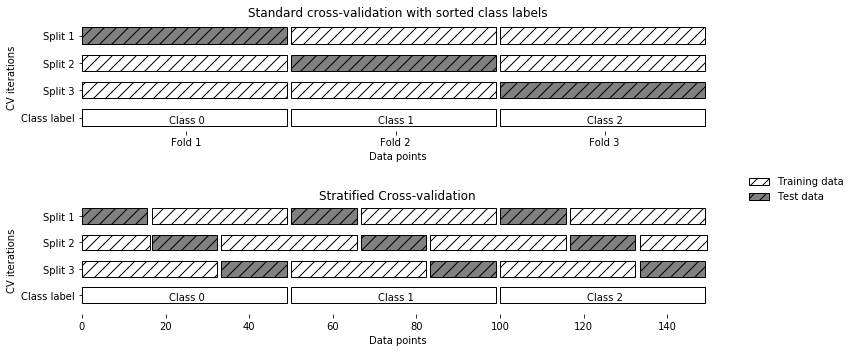

In [9]:
mglearn.plots.plot_stratified_cross_validation()

図を見ればわかるが、層化分割の手法では、訓練セットおよびテストセットの中のクラス割合は、全体の割合と同じになっている。

一般的に、クラス分類器を評価する際は、単純なk分割交差検証よりも層化k分割交差検証を使ったほうがよい。

<br>

##### 5.1.3.1 交差検証の、より詳細な制御

scikit-learnでは、cvパラメータに**交差検証分割器(cross-validation splitter)**を与えることで、データの分割をより詳細に制御できる。

ほとんどの場合はデフォルトの動作(回帰にはk分割交差検証、クラス分類には層化k分割交差検証)でうまくいくが、  
事情があって違う方法を取りたい場合などに活用できる。

***kFold***分類器クラスをインポートすることで実現できる。

In [10]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

In [11]:
print("Cross-validation scores:\n{}".format(
      cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[1.    0.933 0.433 0.967 0.433]


この評価では、単純な5分割交差検証を行っている。3分割交差検証を行った場合は、以下のようになる。

In [12]:
kfold = KFold(n_splits=3)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))

Cross-validation scores:
[0. 0. 0.]


この問題に対処するために、層化k分割交差検証を行うのが一般的だが、別の方法としてデータをランダムにシャッフルする方法もある。

***kFold***の***shuffle***パラメータをTrueにすればよい。

In [13]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print("Cross-validation scores:\n{}".format(
    cross_val_score(logreg, iris.data, iris.target, cv=kfold)))


Cross-validation scores:
[0.9  0.96 0.96]


各分割が全体のクラス割合を保持することは保証できないが、そのままよりはずっと良い。

<br>

##### 5.1.3.2　1つ抜き交差検証

別の交差検証の方法として**1つ抜き交差検証(leave-one-out)**がある。

これは、全データセットの中から1サンプルのみテストとして用い、残りを学習データセットとする方法。

大規模なデータセットに対しては非常に時間がかかるが、小さいデータセットを用いる場合は、より良い推定が可能となる。

In [14]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)
print("Number of cv iterations: ", len(scores))
print("Mean accuracy: {:.2f}".format(scores.mean()))

Number of cv iterations:  150
Mean accuracy: 0.95


<br>

##### 5.1.3.3 シャッフル分割交差検証

シャッフル分割交差検証という手法もある。

これは、毎回***train_size***個の点を選んで訓練とし、***test_size***個の(訓練と重複しない)点を選んで評価する。  
これを***n_iter***回繰り返す。

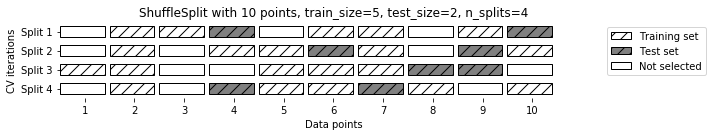

In [15]:
mglearn.plots.plot_shuffle_split()

In [16]:
from sklearn.model_selection import ShuffleSplit
shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.92  0.893 0.947 0.947 0.947 0.96  0.827 0.84  0.933 0.933]


この手法を用いると、訓練セットとテストセットのサイズとは独立して繰り返し回数を制御できる利点もある。
* 例えば5分割交差検証では5個のモデルしか評価できないが、シャッフル分割交差検証では10でも100でも検証できる。

<br>

また、***train_size***と***test_size***の和は1以下に設定できるので、データの一部だけ用いることもできる。
* これを**サブサンプリング**と呼ぶ

<br>

***ShuffleSplit***にも層化版があり***StratifiedShuffleSplit***という分類器も用意されている。  
これを用いると、クラス分類タスクにおいては、より信頼できる結果を得られる。

<br>

##### 5.1.3.4 グループ付き交差検証

グループごとに訓練セットとテストセットを分割する手法もあり、***GroupFold***で用いることができる。

例えば、顔画像から感情を認識するシステムを作る場合など、同じ人の顔画像が訓練セットとテストセットに含まれてしまうと、  
認識性能を誤判定してしまう可能性がある。

新しい顔に対する汎化性能を正確に評価するには、訓練セットとテストセットに含まれている人が重ならないようにする必要がある。

<br>

合成データセットに対してgroups配列を与えてグループ分けする例で確認する。

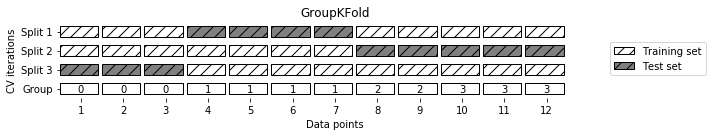

In [17]:

mglearn.plots.plot_group_kfold()

In [18]:
from sklearn.model_selection import GroupKFold

# 合成データセットを生成
X, y = make_blobs(n_samples=12, random_state=0)

# 最初の3サンプルが同じグループに、次の4つが同じグループに、というようにする
groups = [0, 0, 0, 1, 1, 1, 1, 2, 2, 3, 3, 3]

scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print("Cross-validation scores:\n{}".format(scores))

Cross-validation scores:
[0.75  0.8   0.667]


上記例では、12個のデータポイントに対して4つのグループに分けている。

* サンプルはグループごとに並んでいる必要はない。

scikit-learnにはさまざまなケースに対応できる交差検証の手法が実装されている。

https://scikit-learn.org/stable/modules/cross_validation.html

必要に応じて確認。

<br>

---

### 5.2 グリッドサーチ

次は、パラメータをチューニングしてモデルの汎化性能を向上させる方法を確認する。

モデルの重要なパラメータに対して最良の汎化性能を与える設定を見つけるのは非常に困難だが、  
非常に重要なタスクとなる。

scikit-learnではこれを支援するための標準的な方法が実装されており、  
最もよく用いられる方法は、**グリッドサーチ**である。

<br>

具体的に確認するために、RBFカーネル法を用いたSVMの例で確認する。

SVMには2つの重要なパラメータがある。
* gamma : カーネルのバンド幅
* C : 正則化パラメータ

グリッドサーチとは、これら2つのパラメータの組み合わせをそれぞれ評価する方法である。

<br>

#### 5.2.1 単純なグリッドサーチ

単純なグリッドサーチは、この2つのパラメータに対するただのforループで実装できる。

In [19]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
print("Size of training set: {}   size of test set: {}".format(
      X_train.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # SVCをテストセットで評価
        score = svm.score(X_test, y_test)
        
        # 良いスコアだったらスコアとパラメータを保存
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

print("Best score: {:.2f}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Size of training set: 112   size of test set: 38
Best score: 0.97
Best parameters: {'C': 100, 'gamma': 0.001}


<br>

#### 5.2.2 パラメータの過剰適合の危険性と検証セット

上の結果だけみると、このデータセットに対して97%の精度を見つけたと判断したくなるが、それは楽観的すぎる。

なぜなら、テストデータをパラメータのチューニングに使ってしまったからである。  
* テストデータに対して性能が高くなるようなパラメータを探索したので、テストデータに対して性能が良いのは当たり前。

<br>

これは、データを訓練セットとテストセットに分割した理由と同じであり、モデルの評価のためには更に独立したデータセットが必要となる。

この問題を解決する方法の1つは、データを3つのセットに分割する方法である。  
* 訓練セット : モデルを構築する
* 検証セット : モデルのパラメータを選択する
* テストセット : 選択したパラメータの性能を評価する

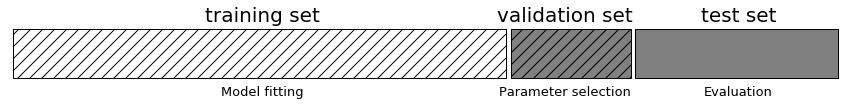

In [20]:
mglearn.plots.plot_threefold_split()

検証セットを用いて最良のパラメータを選択したら、そのパラメータを用いてモデルを再構築する。  

その際、訓練データだけでなく検証データも用いてモデルを構築し、テストセットを用いて評価すれば、  
可能な限りデータを有効に使用してモデルを構築できる。

In [21]:
from sklearn.svm import SVC
# データを訓練セット+検証セットと、テストセットに分割
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

# さらに訓練セットと検証セットに分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)

print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        # SVCを検証セットで評価
        score = svm.score(X_valid, y_valid)
        
        # 良いスコアだったらスコアとパラメータを保存
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


このモデルにおいて、汎化性能を実際に示すスコアは92%であると判断できる。

<br>

訓練セット、検証セット、テストセットを区別することは、機械学習を実運用する上で根本的に重要なことである。  
テストセットは完全に分離しておき、最後の評価にだけ用いる必要がある。

<br>

#### 5.2.3 交差検証を用いたグリッドサーチ

データを訓練セットと検証セット、テストセットに分割する手法は有用ではあるが、データの実際の分割のされ方によって大きく性能が変わる。

そこで、それぞれのパラメータ組み合わせに対して交差検証を行う方法が一般的に採用されている。

In [22]:
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練
        svm = SVC(gamma=gamma, C=C)
        
        # 交差検証を行う
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        
        # 交差検証精度の平均値を計算
        score = np.mean(scores)
        
        # 良いスコアが出たら、スコアとパラメータを記録
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
# 訓練セットと検証セットを合わせて、モデルを再構築する
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

この例では、Cとgammaの組み合わせに対して5分割交差検証を行っており、  
6×6×5=180通りのモデルを訓練する必要がある。

これが交差検証とグリッドサーチを組み合わせる上での最大の欠点となる。

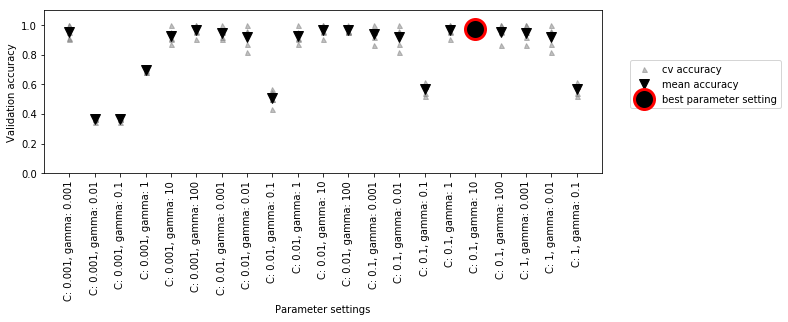

In [23]:
mglearn.plots.plot_cross_val_selection()

<br>

データを分割→グリッドサーチを行い、最後のパラメータを評価する過程を示す。

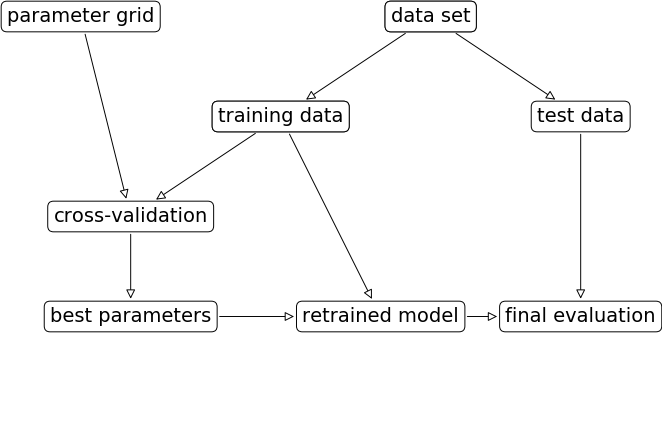

In [24]:
mglearn.plots.plot_grid_search_overview()

<br>

ここまで交差検証を用いたグリッドサーチを実装してきたが、  
scikit-learnではこの手法を***GridSearchCV***クラスで実装している。

具体的な手法を確認する。

In [25]:
# パラメータと評価したい値を辞書型で定義
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
print("Parameter grid:\n{}".format(param_grid))

Parameter grid:
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [26]:
# モデル(今回はSVC)、パラメータ空間を指定
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)

テストセットは別に分割しておく。

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, random_state=0)

In [28]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

***GridSearchCV***オブジェクトの***fit***メソッドを呼び出すと、最適なパラメータ設定を探索するだけでなく、  
交差検証で最も良いスコアだったパラメータを用いて、自動的に訓練セット全体に対して新しいモデルを学習する。

つまり、本項はじめの処理「～～～svm.fit(X_trainval, y_trainval)」まで行った状態になる。

***GridSearchCV***クラスで得られたモデルに対しては、***predict***メソッドと***score***メソッドで結果にアクセスできる。

In [29]:
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

Test set score: 0.97


交差検証でパラメータを選択した結果、テストセットに対して97%のモデルを見つけることができた。

重要なのは、このパラメータを選ぶのに**テストセットを使っていない**という点。

見つけたパラメータは***best_params_***属性に、交差検証精度(そのパラメータ設定に対する様々なFoldの平均精度)は***best_score_***属性に、  
また、最良のパラメータを用いて訓練セット全体を用いて訓練したモデルは***best_estimator_***属性に格納されている。

In [30]:
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best parameters: {'C': 100, 'gamma': 0.01}
Best cross-validation score: 0.97
Best estimator:
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


<br>

#### 5.2.3.1 交差検証の結果の解析

グリッドサーチは計算コストが高いので、比較的粗くて小さいグリッドから始めるのが良い。

その時は、グリッドサーチの結果を***cv_results_***属性を確認するとよい。

対象で詳細な情報が格納されているので、pandasのDataFrameに変換してから見ると便利である。

In [31]:
results = pd.DataFrame(grid_search.cv_results_)

# 最初の5行を表示
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.96e-04,3.98e-04,0.00e+00,0.00e+00,0.001,0.001,"{'C': 0.001, 'gamma': 0.001}",0.38,0.35,0.36,0.36,0.38,0.37,0.01,22,0.36,0.37,0.37,0.37,0.36,0.37,2.85e-03
1,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.001,0.01,"{'C': 0.001, 'gamma': 0.01}",0.38,0.35,0.36,0.36,0.38,0.37,0.01,22,0.36,0.37,0.37,0.37,0.36,0.37,2.85e-03
2,3.99e-04,4.89e-04,1.99e-04,3.97e-04,0.001,0.1,"{'C': 0.001, 'gamma': 0.1}",0.38,0.35,0.36,0.36,0.38,0.37,0.01,22,0.36,0.37,0.37,0.37,0.36,0.37,2.85e-03
3,5.93e-04,4.85e-04,0.00e+00,0.00e+00,0.001,1,"{'C': 0.001, 'gamma': 1}",0.38,0.35,0.36,0.36,0.38,0.37,0.01,22,0.36,0.37,0.37,0.37,0.36,0.37,2.85e-03
4,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.001,10,"{'C': 0.001, 'gamma': 10}",0.38,0.35,0.36,0.36,0.38,0.37,0.01,22,0.36,0.37,0.37,0.37,0.36,0.37,2.85e-03


各行は特定のパラメータ組み合わせに対する様々な値が格納されている。

今回は2次元(***C***と***gamma***)のパラメータグリッドを探索しているので、ヒートマップで可視化すると分かりやすい。

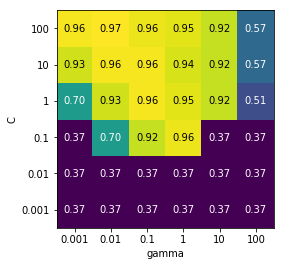

In [32]:
scores = np.array(results.mean_test_score).reshape(6, 6)

# plot the mean cross-validation scores
mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels=param_grid['gamma'],
                      ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

この結果から、以下のような所感を得られる。

* 良い性能を得るためにはパラメータの設定が非常に重要
* パラメータのレンジは十分大きくしなければいけない

<br>

2個目に対して、レンジが適切でない場合を確認する。

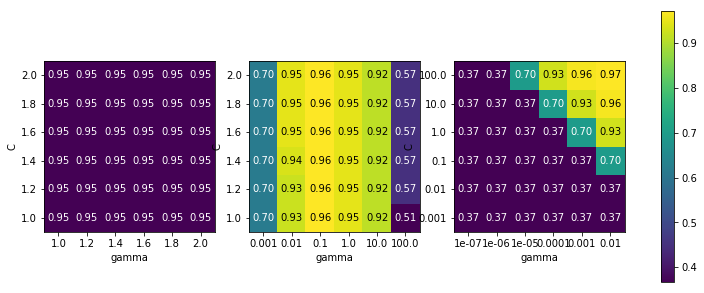

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))

param_grid_linear = {'C': np.linspace(1, 2, 6),
                     'gamma':  np.linspace(1, 2, 6)}

param_grid_one_log = {'C': np.linspace(1, 2, 6),
                      'gamma':  np.logspace(-3, 2, 6)}

param_grid_range = {'C': np.logspace(-3, 2, 6),
                    'gamma':  np.logspace(-7, -2, 6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log,
                           param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6, 6)

    # plot the mean cross-validation scores
    scores_image = mglearn.tools.heatmap(
        scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
        yticklabels=param_grid['C'], cmap="viridis", ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

左はまったく変化がないため、レンジを極端な値で設定してみて、精度が変化するか確認するとよい。

真ん中では、***gamma***軸でしか変化していない。

右は、左下あたりは変化がなく右上の部分で精度がよさそうである。レンジを右上の方にずらして確認する。

<br>

#### 5.2.3.2 グリッドでないサーチ空間

***GridSearchCV***は、通常全てのパラメータのすべての組み合わせに対して探索するが、限定することもできる。

例えば、SVCには***kernel***パラメータがあるが、***kernel***の種類に応じて用いるパラメータを変えたい場合がある。  
そんな時は、以下のように***param_grid***に**辞書型のリスト形式**で設定する。

In [34]:
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]}]
print("List of grids:\n{}".format(param_grid))

List of grids:
[{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [35]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5,
                          return_train_score=True)
grid_search.fit(X_train, y_train)
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best cross-validation score: 0.97


In [36]:
results = pd.DataFrame(grid_search.cv_results_)
# we display the transposed table so that it better fits on the page:
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.0004,0.0002,0.0006,0.00079,0.0008,0.0006,0.0002,0.00021,0.0004,0.0004,0.0006,0.00079,0.0006,0,0.0002,0.0006,0,0.0006,0,0.0006,0.0002,0.0004,0,0.0008,0.0004,0.0002,0.0004,0.0004,0.0006,0.0008,0.0002,0.0004,0,0.0004,0.0004,0.0006,0.0004,0.0002,0.0002,0.00039,0.0002,0.0002
std_fit_time,0.00049,0.0004,0.00049,0.0004,0.0004,0.00049,0.0004,0.00041,0.00049,0.00049,0.00049,0.0004,0.00049,0,0.0004,0.00049,0,0.00049,0,0.00049,0.0004,0.00049,0,0.0004,0.00049,0.0004,0.00049,0.00049,0.00049,0.0004,0.0004,0.00049,0,0.00049,0.00049,0.00049,0.00049,0.0004,0.0004,0.00048,0.0004,0.0004
mean_score_time,0.00019,0,0.0002,0.0002,0,0,0,0.0002,0.00039,0.0002,0.0004,0,0.0002,0,0,0.0004,0,0.0004,0.0004,0,0,0,0.0006,0,0.0004,0.0002,0,0.0002,0.0002,0.0002,0,0,0.0002,0,0.0004,0.0002,0.0002,0,0.0002,0.0002,0.0004,0.0004
std_score_time,0.00039,0,0.0004,0.0004,0,0,0,0.0004,0.00048,0.0004,0.00049,0,0.0004,0,0,0.00049,0,0.00049,0.00049,0,0,0,0.00049,0,0.00049,0.0004,0,0.0004,0.0004,0.0004,0,0,0.0004,0,0.00049,0.0004,0.0004,0,0.00041,0.0004,0.00049,0.00049
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.38,0.71,0.92,1,0.38,0.38,0.71,0.88,1,0.92,0.88,0.5,0.88,1,0.96,0.92,0.88,0.54,1,1,0.96,0.92,0.88,0.54,0.38,0.92,0.96,1,0.96,0.96
split1_test_score,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.35,0.7,0.91,0.91,0.35,0.35,0.7,0.91,0.96,0.96,0.96,0.43,0.91,0.96,0.96,0.96,0.96,0.52,0.96,0.96,1,1,0.96,0.52,0.35,0.83,0.91,0.96,1,1


<br>

#### 5.2.3.3 異なる交差検証手法を用いたグリッドサーチ

***GridSearchCV***は、***cross_val_score***と同様に交差検証の分割器を***cv***パラメータで設定できる。

特に、データセットが非常に大きい場合や、モデルの計算に非常に時間がかかる場合など、  
***ShuffleSplit***もしくは***StratifiedShuffleSplit***を用いて、***n_iter=1***とするとよい。

<br>

#### 5.2.3.4 ネストした交差検証

先の例では、元のデータを訓練セットとテストセットに分割し、訓練セット上で交差検証を行うところまで試した。  
しかし、これではデータの一度だけの分割に結果が依存してしまう。

そこで、元のデータの訓練セットとテストセットの分割も交差検証で何度も分割する手法を用いると、さらに安定した結果を得られる。  
* これを**ネストした交差検証**と呼ぶ。

ネストした交差検証では、外側にループを設けて、そこでデータを訓練セットとテストセットに分割する。  
それぞれの分割でグリッドサーチを実行し、それぞれの分割に対して最良のセッティングでテストセットを評価した結果が返ってくる。

<br>

この結果はスコアのリストであってモデルではないし、パラメータの設定でもない。  
分かるのはこのモデルのグリッドから見つけた最適なパラメータによる汎化性能である。

ネストした交差検証を実行するのは、***cross_val_score***を***GridSearchCV***のインスタンスをモデルとして呼び出す。

In [37]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5),
                         iris.data, iris.target, cv=5)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

Cross-validation scores:  [0.967 1.    0.967 0.967 1.   ]
Mean cross-validation score:  0.9800000000000001


このネストした交差検証の結果は、「SVCはirisデータセットに対して交差検証精度の平均で98%を達成することができる」となる。

ここでは、内側のループと外側のループ両方に、層化5分割交差検証を用いた。  
***param_grid***は6×6=36の組み合わせがあるので、36×5×5=900通りもモデルを構築している。

つまり、非常に計算コストが高いので、データセットが大きい場合や訓練に時間がかかるモデルなどの場合は注意が必要。

<br>

上の例では1行で記述しているため、何をしているのか理解が難しい。  
次のforループで記述したもので理解してほしい。

In [38]:

def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    outer_scores = []
    # 外側の交差検証による個々の分割に対するループ
    # (splitメソッドはインデックスを返す)
    for training_samples, test_samples in outer_cv.split(X, y):
        # 内側の交差検証を用いて、裁量のパラメータ設定を見つける
        best_parms = {}
        best_score = -np.inf
        
        # 個々のパラメータ設定に対してループ
        for parameters in parameter_grid:
            # 内側の分割に対するスコアを格納
            cv_scores = []
            
            # 内側の交差検証のループ
            for inner_train, inner_test in inner_cv.split(
                    X[training_samples], y[training_samples]):
                # 与えられたパラメータと訓練セットでクラス分類器を訓練
                clf = Classifier(**parameters)
                clf.fit(X[inner_train], y[inner_train])
                
                # 内側のテストセットを評価
                score = clf.score(X[inner_test], y[inner_test])
                cv_scores.append(score)
                
            # 内側の分割に対するスコアの平均を算出
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # これまでのより性能がよいなら、パラメータを記憶
                best_score = mean_score
                best_params = parameters
                
        # 最良のパラメータセットと、外側の訓練セットを用いてクラス分類器を構築
        clf = Classifier(**best_params)
        clf.fit(X[training_samples], y[training_samples])
        
        # 外側のテストセットで評価する
        outer_scores.append(clf.score(X[test_samples], y[test_samples]))
        
    return np.array(outer_scores)

In [39]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold
scores = nested_cv(iris.data, iris.target, StratifiedKFold(5),
                   StratifiedKFold(5), SVC, ParameterGrid(param_grid))
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.967 1.    0.967 0.967 1.   ]


<br>

#### 5.2.3.5 交差検証とグリッドサーチの並列化

交差検証やグリッドサーチは有用な方法であるが計算コストが高い。
そこで、複数のCPUコアやクラスタを用いて並列化することが理想的である。

***GridSearchCV***や***cross_val_score***では、パラメータ***n_jobs***に利用したいコア数を設定することで、複数のコアを利用することができる。
* n_jobs=-1を設定すると、利用できるすべてのコアを利用する。

<br>

scikit-learnでは**ネストした並列実行はサポートされていない**。  
つまり、モデルの中で***n_jobs***オプションを使っていたら、***GridSearchCV***では使うことができない。

また、データセットやモデルが非常に大きい場合、たくさんのコアを使おうとするとメモリの消費が多くなるので注意が必要。

<br>

---

## おわり

誤字脱字、不明点あればご連絡ください。